# H5 Spike Detector for Scaled and Filtered Data

### This version assumes you have pre-processed the data in h5_explorer
- Reads in a h5 file of scaled and filtered experimental data from the Leaf Labs Willow System (h5_explorer.ipynb)
- Smooths the time series and detects spikes above threshold (set by median +/- range of probe noise)
- Plots the average trace for each channel according to probe geometry
- Finds the width, peak amplitude, peak time, and inter-peak interval for each event
- Saves the raw and scaled data to a csv file for analysis in any analysis program (SigmaPlot, Origin, etc)

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = 'experiment_C20200330-175336_filtered_64.h5'
shank_num = 1 # starting at 1
fs = 30000 # sample rate
window = [0, 30] # time window of analysis in seconds (for filtering, 4 mins max for most computers)
columns = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], 
            [22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41], 
            [42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]]         
lowcut = 400 # Hz for bandpass filter
highcut = 5000 # Hz for bandpass filter
order = 6 # For bandpass filter 

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd
import scipy 
import csv

## Read in the Multichannel Data
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working

In [3]:
columns = np.array(columns)
f_data = h5py.File(datafile, 'r')
xs = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data')  # actual data in microvolts (y)
xs = xs[window[0]*fs:window[1]*fs] # Keep only the datapoints within our time window
ys = ys[window[0]*fs:window[1]*fs, :] # Keep only the datapoints within our time window
display (HTML("<hr><h4>Data consists of " + str(ys.shape[1]) + 
              " columns of data (channels, x) and " + str(ys.shape[0]) + 
              " rows of data (measurements, y)." + "The recording is " +
              str(round(ys.shape[0]/(fs * 60),3)) + " mins long. <hr>"))

## Savitzky-Golay Smoothing (Better than stringent band-pass)

In [4]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')
    
smoothed = sgolay2d( ys, window_size=41, order=4)


## Plot a sample of the smoothed data
- If the scripts are running too slow, skip the boxes with figures/plots

In [5]:
start = 0   # Start time of sample (in seconds)
end = 1000  # End time of sample (in seconds)
c = 4       # Channel to analyze 

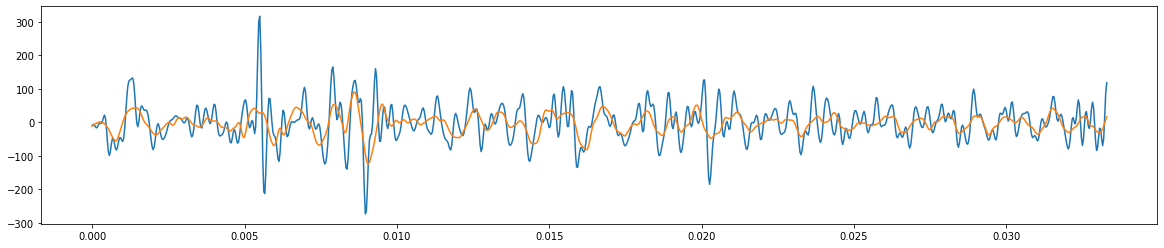

In [6]:
fig, ax = plt.subplots(figsize = (20,4))
ax.plot(xs[start:end]/fs,ys[start:end,c])
ax.plot(xs[start:end]/fs,smoothed[start:end,c])
plt.savefig (datafile.replace('.h5','_smoothed_chan' + str(c) + '.png'))

## Search for events with 1 threshold for all channels
- Search in 5s windows, get mean of smoothed data and sd
- from start to end of window find any peaks that are greater than 1 sd of baseline or compare MSE?
- save all data points from -3 to + 3 ms around peak and note the time of the peak
    - later look for overlap between epochs to determine wavelets vs single spikes 
    - i.e. granule cell activity from simple spikes
- Experimented with dataframes, np.arays, and dicts for working with these long lists of events and dataframes were the worst for speed

In [7]:
start_search = 0    # Time to start looking for events (in seconds)
end_search = 1      # Time to stop looking for events (in seconds)
threshold = 0.5       # Multiplier of the std of the smoothed mean for every 10ms with 10% overlap

In [8]:
def event_search(raw, smooth, start, end, thresh): 
    start = int(start * fs)
    end = int(end*fs)
    mn = fs-150 # minimum length of analysis window (0.995 s)
    peaks_x = {} # dict to catch peak times 
    peaks_y = {} # dict to catch peak amps
    peaks_b = {} # dict to catch peak baseline amps
    events_x = {} # dict to catch event trace x (3 ms before and after peak)
    events_y = {} # dict to catch event trace y (3 ms before and after peak)
    events_b = {} # dict to catch event trace baseline (3 ms before and after peak)
    print('Analyzing channel: ', end = ' ')
    for j in np.arange(0,64):
        print(j, end = ' ')
        i = start
        epoch = 0
        peak_x = []
        peak_y = []
        peak_b = []
        rep = 0
        while i < end-11: # search all the rows 
            if i % mn == 0 and i < end - mn: # moving window every 10ms
                savg = np.median(abs(smooth[i:i+mn,j]))
                ssd = np.std(smooth[i:i+mn,j])*threshold
            if raw[i,j] > savg *ssd  and raw[i,j] > max(raw[i+1:i+10,j]) and raw[i,j] > raw[i-1,j] and i-10 >= 0:
                peak_x.append(i)
                peak_y.append(raw[i,j])
                peak_b.append(savg)
                events_x['xCh'+str(j)+'_'+str(rep)] = list(range(i-10,i+10))
                events_y['yCh'+str(j)+'_'+str(rep)] = raw[i-10:i+10,j]
                rep = rep + 1
            i = i + 1
        peaks_x[str(j)] = peak_x
        peaks_y[str(j)] = peak_y
        peaks_b[str(j)] = peak_b
    peaks = [peaks_x,peaks_y,peaks_b]
    events = [events_x, events_y]
    return peaks, events
            
peaks, events = event_search (ys, smoothed, start_search, end_search, threshold)            

Analyzing channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## (Optional) Search for events with a different threshold for each channel
- same as with 1 threshold for all, just adjust the threshold variable to be an array with the same dimensions as the `columns` variable in the User Input section at the top of the notebook.
- Note that there is one set of brackets, not two for thresholds. 

In [9]:
start_search = 0    # Time to start looking for events (in seconds)
end_search = 1      # Time to stop looking for events (in seconds)
thresholds = [0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.1, 0.2, 2, 0.5, 0.4, 1, 1, 1, 0.3, 1, 2, 1, 0.2, 0.5, 
              0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.1, 0.2, 2, 0.5, 0.4, 1, 1, 1, 0.3, 1, 2, 1, 
              0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 0.5, 0.1, 0.2, 0.01, 0.5, 0.4, 0.2, 0.2, 0.2, 0.3, 1, 2, 1, 0.2, 0.5]       

In [10]:
def event_search(raw, smooth, start, end, thresh): 
    start = int(start * fs)
    end = int(end*fs)
    mn = fs-150 # minimum length of analysis window (0.995 s)
    peaks_x = {} # dict to catch peak times 
    peaks_y = {} # dict to catch peak amps
    peaks_b = {} # dict to catch peak baseline amps
    events_x = {} # dict to catch event trace x (3 ms before and after peak)
    events_y = {} # dict to catch event trace y (3 ms before and after peak)
    events_b = {} # dict to catch event trace baseline (3 ms before and after peak)
    print('Analyzing channel: ', end = ' ')
    for j in np.arange(0,64):
        print(j, end = ' ')
        i = start
        epoch = 0
        peak_x = []
        peak_y = []
        peak_b = []
        rep = 0
        while i < end-11: # search all the rows 
            if i % mn == 0 and i < end - mn: # moving window every 10ms
                savg = np.median(abs(smooth[i:i+mn,j]))
                ssd = np.std(smooth[i:i+mn,j])*thresh[j]
            if raw[i,j] > savg *ssd  and raw[i,j] > max(raw[i+1:i+10,j]) and raw[i,j] > raw[i-1,j] and i-10 >= 0:
                peak_x.append(i)
                peak_y.append(raw[i,j])
                peak_b.append(savg)
                events_x['xCh'+str(j)+'_'+str(rep)] = list(range(i-10,i+10))
                events_y['yCh'+str(j)+'_'+str(rep)] = raw[i-10:i+10,j]
                rep = rep + 1
            i = i + 1
        peaks_x[str(j)] = peak_x
        peaks_y[str(j)] = peak_y
        peaks_b[str(j)] = peak_b
    peaks = [peaks_x,peaks_y,peaks_b]
    events = [events_x, events_y]
    return peaks, events

thresholds = np.array(thresholds)
peaks, events = event_search (ys, smoothed, start_search, end_search, thresholds)            

Analyzing channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Plot a subset of the events

In [11]:
start = int(0 * fs) # Start of window to see how well search performed   
end = int(29.5* fs) # End of window to see how well search performed
chans = list(np.arange(0,64,4)) # Range of channels to preview (start, end, step)

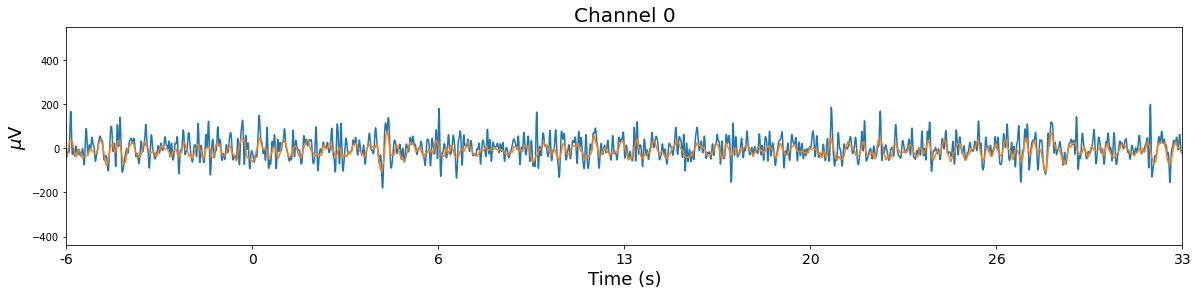

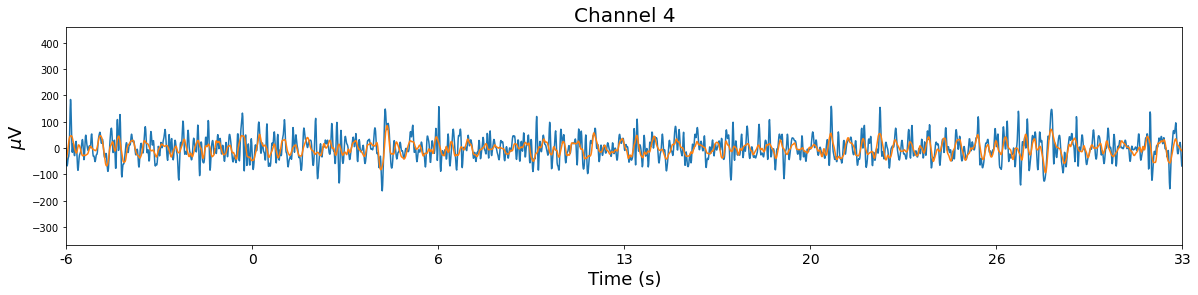

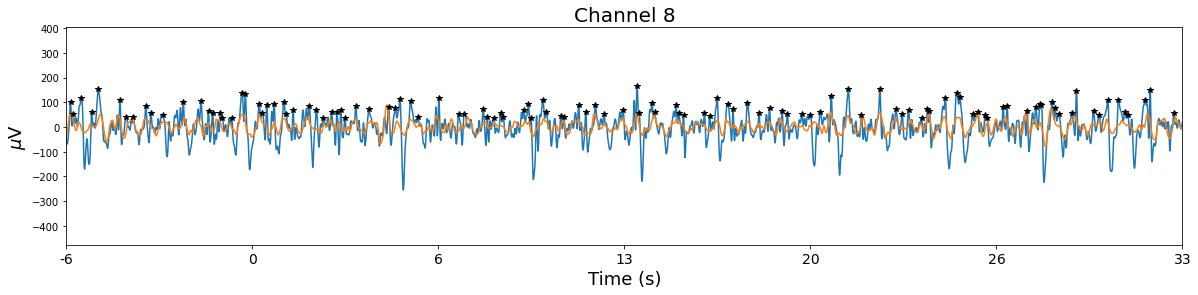

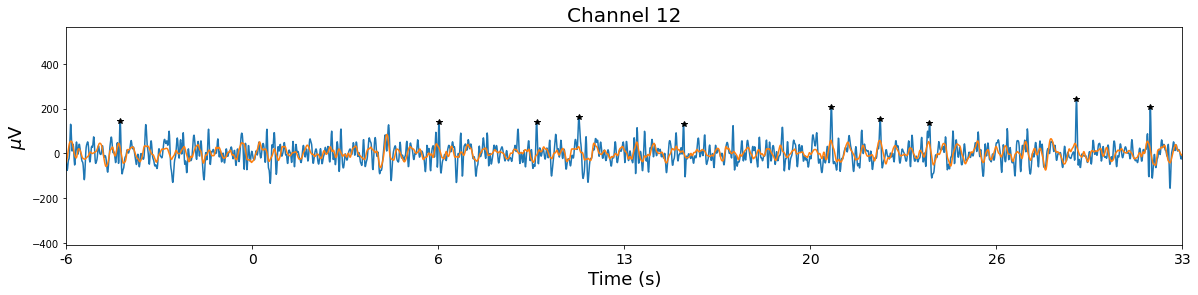

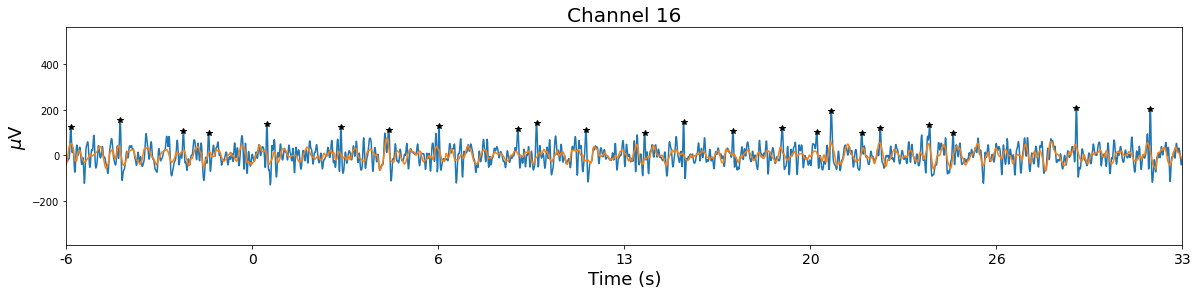

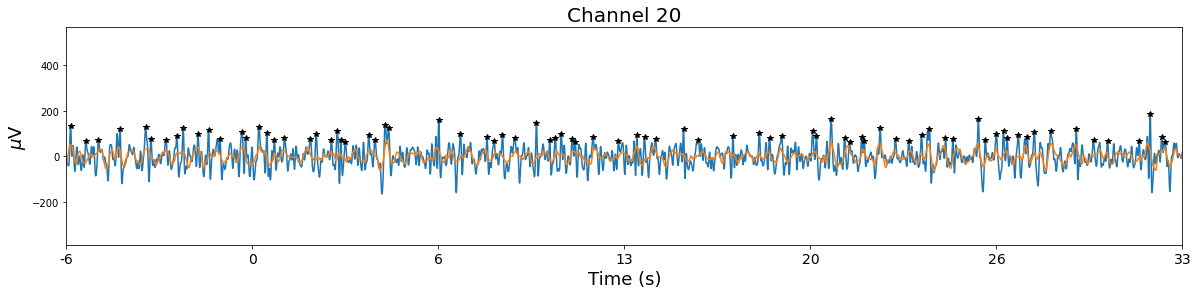

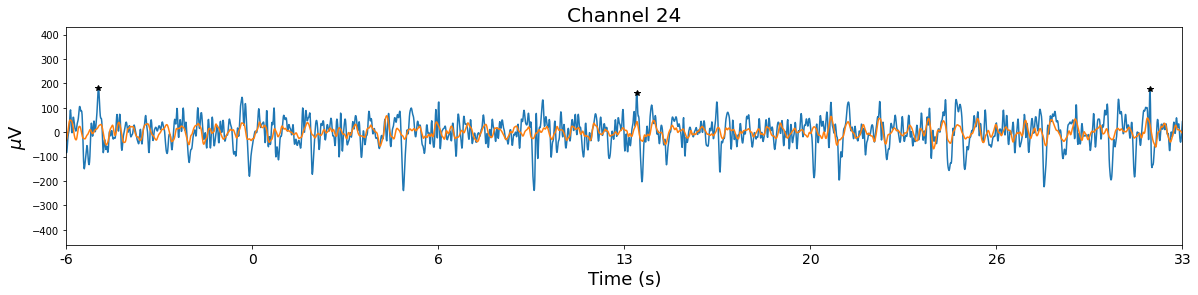

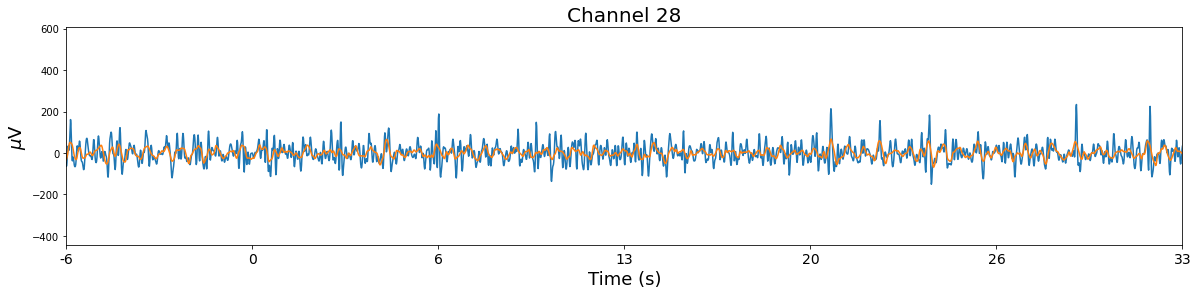

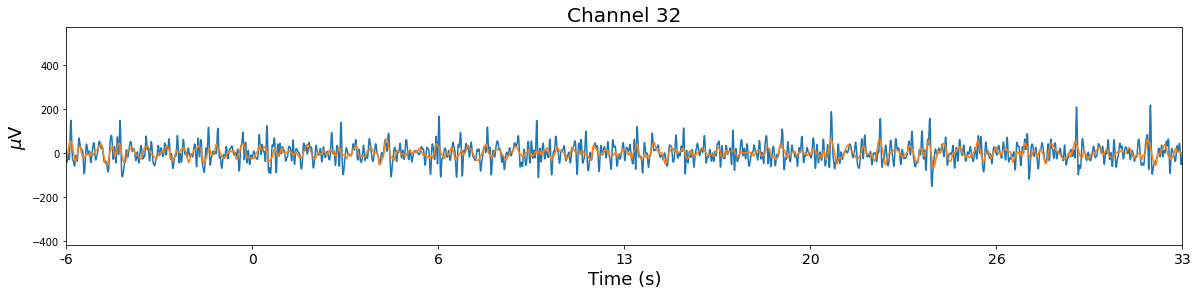

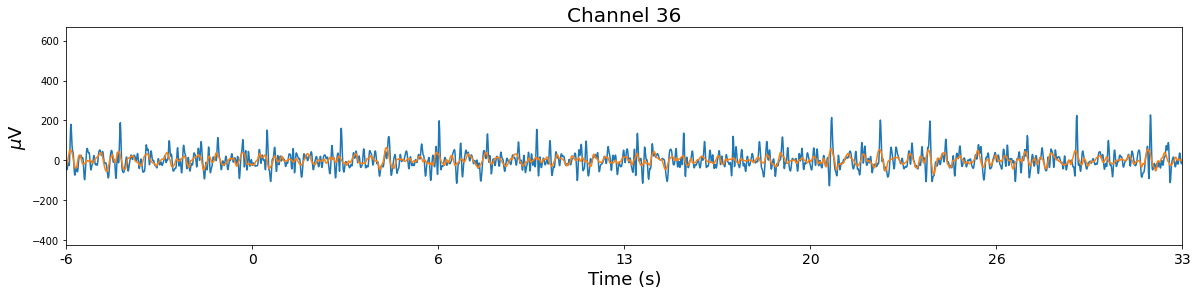

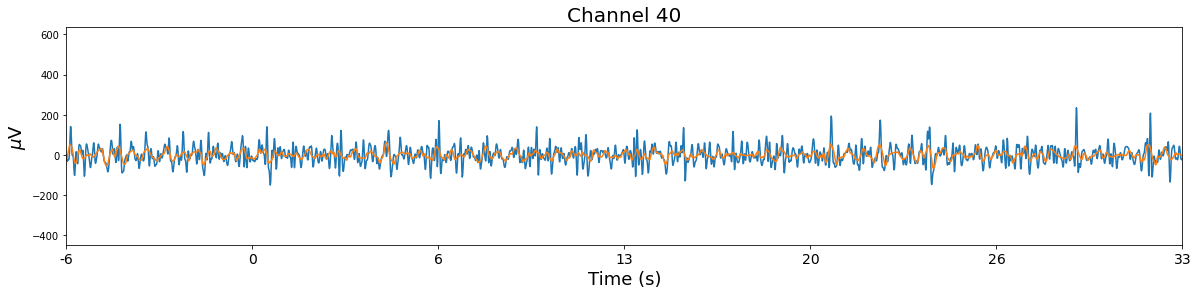

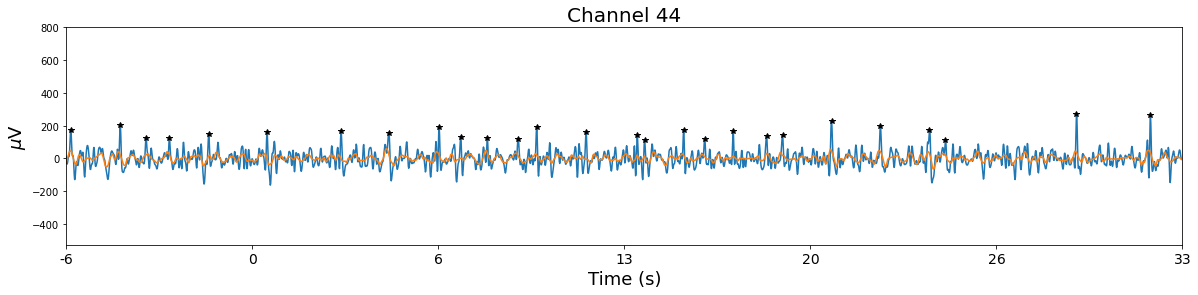

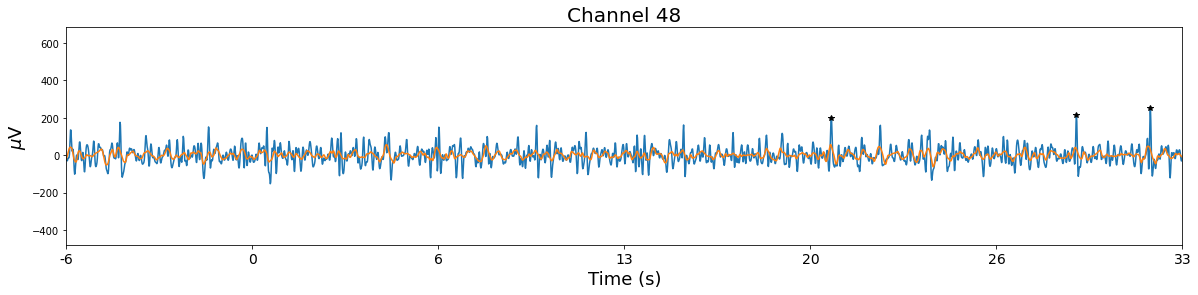

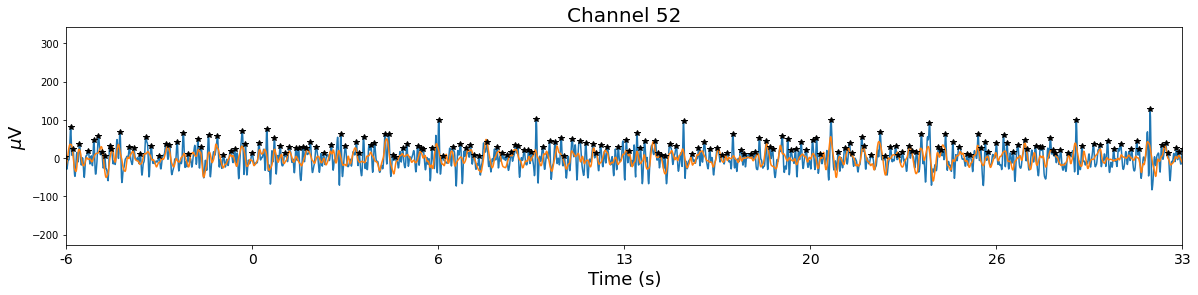

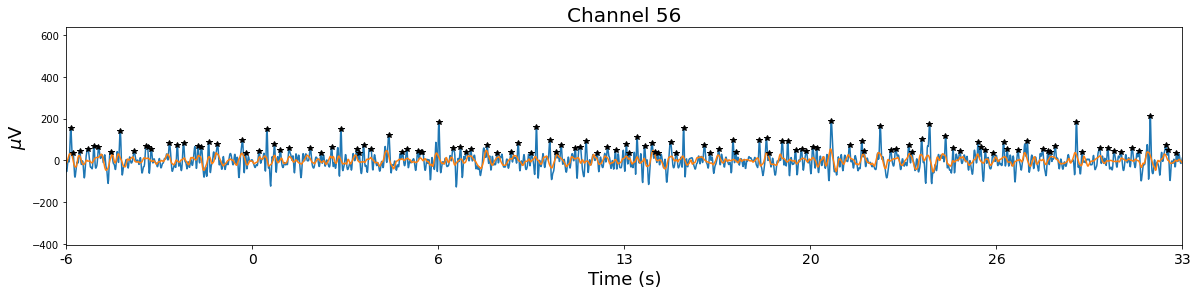

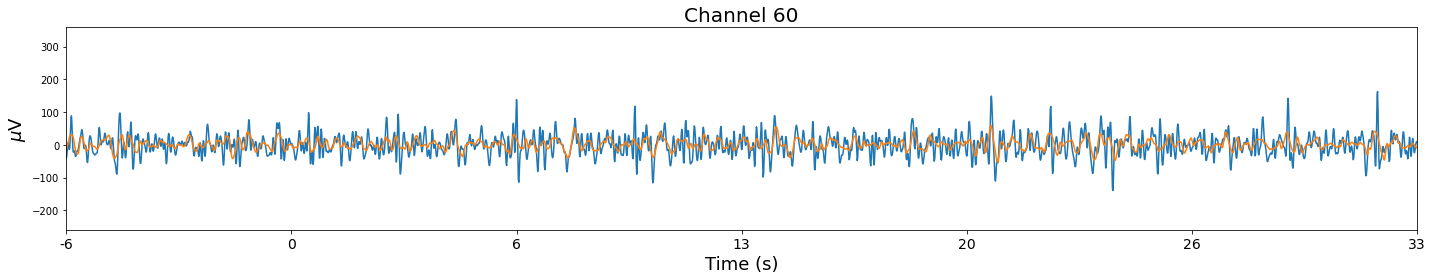

In [12]:
for chan in chans:
    fig, ax = plt.subplots(figsize = (20,4))
    ax.plot(xs[start:end],ys[start:end,chan])
    ax.plot(xs[start:end],smoothed[start:end,chan])
    ax.plot(peaks[0][str(chan)],
        peaks[1][str(chan)], 
        ls = 'none', marker = '*', markersize = 6, color = 'black')
    #ax.axhline (peaks[2][str(chan)][50], ls = ':')
    ax.set_title("Channel " + str(chan), fontsize = 20)
    xticks = ax.get_xticks()
    xticks = [int(t/30000) for t in xticks]
    ax.set_xticklabels (xticks, fontsize = 14)
    ax.set_ylabel(r'$\mu$V', fontsize = 18)
    ax.set_xlabel('Time (s)', fontsize = 18)
    ax.set_xlim(0.2 *fs,.3*fs)
    #ax.set_ylim(-100,200)
plt.tight_layout()
plt.savefig (datafile.replace('.h5','_scatterpeaks.png'))

## Convert Events Dictionaries to Dataframes for easy file handling
- These can be used to reconstruct raw traces of individual events in other programs

In [16]:
def get_index_from_dict(dct):
    """Finds the max length of rows for all keys in a dict"""
    max_len = 0
    for keys,values in dct.items():
        for key in keys:
            tmp = len(values)
            if tmp > max_len:
                max_len = tmp
    max_index = list(range(0,max_len))
    return max_index, max_len
idx,id_len = get_index_from_dict(events[0])
df_events_x = pd.DataFrame(events[0], columns = events[0].keys(), index = idx)
df_events_y = pd.DataFrame(events[1], columns = events[1].keys(), index = idx)
df_events = df_events_x.join(df_events_y)

## Save the events and peaks to csv files
- These may get too big to open in excel
- If so, break them down into 64 channels each with 2 min recordings
- Use this as a checkpoint. If your kernel crashes, you can recreate the dicts quickly

In [17]:
df_events.to_csv(datafile.replace('.h5', '_event_traces.csv'))

## Get the mean traces for each event

In [18]:
widths = {} # Dict for width
ipis = {} # Dict for Iinter-peak interval
x = list(range(0,20))
y_means = []
print("Averaging channel: ", end = ' ')
for chan in np.arange(0,64):
    print(str(chan), end = ' ')
    avg_cols = pd.DataFrame()
    x_width = []
    ipi = []
    for key in events[1].keys():
        if 'yCh'+str(chan) in key:
            # Get y values to average
            avg_cols[key] = events[1][key] 
            
            # Get interevent interval
            ipi_list = peaks[0][str(chan)]
            for i in np.arange(len(ipi_list)-1):
                ipi.append(ipi_list[i+1]-ipi_list[i])
            # Get width of peak
            tmp1 = 0
            tmp2 = 0
            events_list = events[1][key]
            for x in np.arange(10,0,-1):
                if events_list[x] < events_list[(x-1)]:
                    tmp1 = x  
            for x in np.arange(11,19):
                if events_list[x] > events_list[(x+1)]:
                    tmp2 = x
            x_width.append(tmp2-tmp1)
        
        widths[str(chan)] = x_width
        ipis[str(chan)] = ipi
    y_mean = avg_cols.transpose().mean()
    y_means.append(y_mean)   

Averaging channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

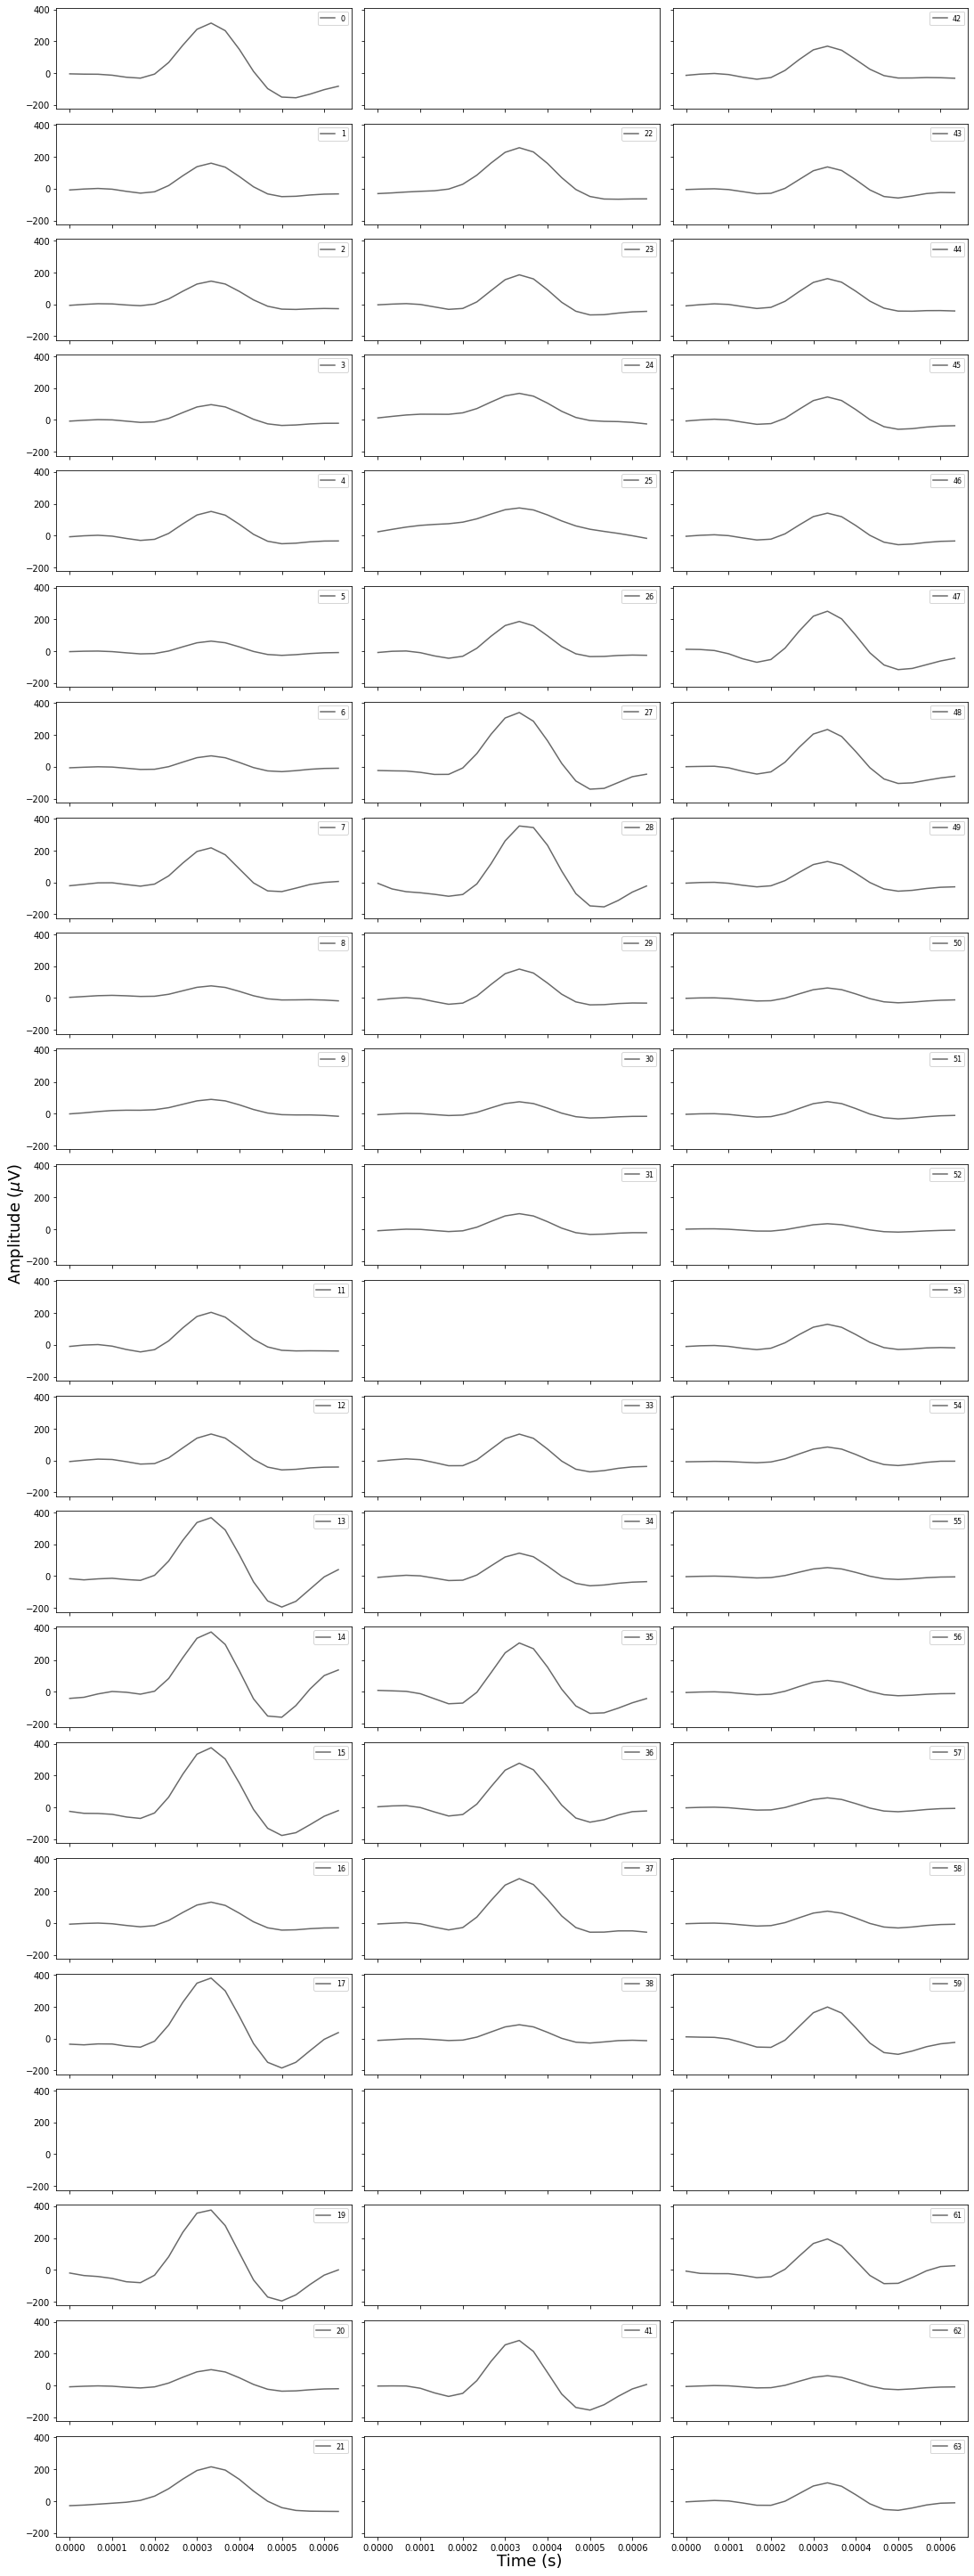

In [19]:
def grid_plot_events(x,y):
    chan_list = []
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (len(columns[0]),int(columns.shape[0]), figsize =(15,40), sharex = True, sharey = True)
    x = [i/(fs) for i in x]
    j = 0
    for j in np.arange (0,columns.shape[0]):
        for i,col in enumerate(columns[j]): 
            print(col, end = ' ')
            if j == 1: # Offset for middle row (grid is 66 panels, but we only have 64 channels. Middle row is shorter) 
                i = i + 1
            if np.isnan(y_means[col]).all():
                continue
            else:
                chan_list.append(col)
            ax[i][j].plot(x, y_means[col], color = 'dimgray', 
                            label=str(col)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            plt.tight_layout()
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (s)', va='center',  fontsize = 18)
    plt.savefig (datafile.replace('.h5','.png'))
    display(HTML('<hr>'))

x = list(range(len(events[0]['xCh0_0'])))
grid_plot_events(x, y_means)
plt.savefig (datafile.replace('.h5','_peakgrid.png'))

## Format final output
- takes a long time. DFs will add processing time, so if you have to pull data, do it from the peaks and events dictionaries, not the dataframe
- ids are 'Ch + channel# + event#'

In [20]:
f_out = open(datafile.replace('.h5','_event_data.csv'), "w")
writer = csv.writer(f_out)
header = ['id','time_datapoints','time_seconds','peak_amplitude_microvolts','peak_width_datapoints',
          'peak_width_seconds','interstimulus_interval_datapoints', 'interpeak_interval_seconds',
          'baseline_amplitude_microvolts']
writer.writerow(header)
print('Working on chan: ', end = ' ')
for chan in np.arange(64):
    # load the data for the channel upfront for speed
    str_chan = str(chan)
    row_range = range(len(peaks[0][str(chan)]))
    w_list = widths[str_chan]
    x_list = peaks[0][str_chan]
    y_list = peaks[1][str_chan]
    b_list = peaks[2][str_chan]
    n_list = ipis[str_chan]
    print(chan, end = ' ')
    for i in row_range:
        x_dp = x_list[i]
        y = y_list[i]
        b = b_list[i]
        if i == 0:
            w = w_list[i]
            n = np.nan
            row = ['Ch'+str(chan)+str(x_dp),x_dp,(x_dp/fs),y, w, (w/fs), n, (n/fs), b]
            writer.writerow(row)
        elif i!=0 and i < len(widths[str(chan)]):
            w = w_list[i]
            n = n_list[i]
            row = ['Ch'+str(chan)+str(x_dp),x_dp,(x_dp/fs),y, w, (w/fs), n, (n/fs), b]
            writer.writerow(row)
f_out.close()

Working on chan:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Format Output to Nex 
- column values are Channel number in the format (Ch1)
- row values are peak times in seconds

In [21]:
cols = {}
max_rows = max([len(peaks[0][str(chan)]) for chan in np.arange(64)])
print('Working on chan: ', end = ' ')
for chan in np.arange(64):
    str_chan = str(chan)
    cols['Ch'+str(chan)] = [peak/fs for peak in peaks[0][str_chan]]
    cols['Ch'+str(chan)].extend(np.nan for t in np.arange(len(peaks[0][str_chan]),max_rows)) # Fill in missing values with NaN
    
    print(chan, end = ' ')
df = pd.DataFrame(cols, index = list(np.arange(max_rows)))
df = df.to_csv(datafile.replace('.h5','_events_nex.csv'), index = False)


Working on chan:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

In [22]:

print(max_rows)

1884
